#### sklearn/SVM tuning with MNIST

##### Libraries

In [24]:
using MLDatasets           # mnist
using Images
using PreprocessingImages; pim = PreprocessingImages
using PreprocessingArrays; pa  = PreprocessingArrays

using MLJ                  # make_blobs, rmse, confmat, categorical
using MLDataUtils          # label, nlabel, labelfreq
using PyCall               # required by ScikitLearn

using Metrics              # r2-score
using Random
using Plots; gr()
using StatsPlots
using DataFrames

##### Functions

In [25]:
# metrics
function printMetrics(ŷ, y)
    display(confmat(ŷ, y))
    acc = accuracy(ŷ, y)
    f1  = multiclass_f1score(ŷ, y)
    println("accuracy: ", round(acc; digits=3))
    println("f1-score: ", round(f1;  digits=3))
    
    return (acc, f1)
end

printMetrics (generic function with 1 method)

##### Dataset

(28, 28, 60000)

1×5 adjoint(::Vector{Int64}) with eltype Int64:
 5  0  4  1  9

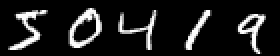

In [26]:
# load mnist
datasetX,    datasetY    = MNIST(:train)[:]
validationX, validationY = MNIST(:test)[:]

display( size(datasetX) )

img  = datasetX[:, :, 1:5]
img2 = permutedims(img, (2, 1, 3))

display(datasetY[1:5]')
mosaicview( Gray.(img2) ; nrow=1)

In [27]:
# split trainset, testset from dataset
Random.seed!(1)
(trainX, trainY), (testX, testY) = stratifiedobs((datasetX, datasetY), p = 0.7)
size(trainX), size(testX), size(validationX)

((28, 28, 42001), (28, 28, 17999), (28, 28, 10000))

##### Preprocessing

In [28]:
function preprocess(X, y)
    newX = pim.batchImage2DF(X)
    #coerce!(newX)   # no need, all scitypes are Continuous in this example
    new_y = coerce(y, OrderedFactor)
    
    return (newX, new_y)
end

X, y = preprocess(trainX, trainY);

In [29]:
scitype(X)

Table{AbstractVector{Continuous}}

In [30]:
scitype(y)

AbstractVector{OrderedFactor{10}} (alias for AbstractArray{OrderedFactor{10}, 1})

##### Pipe the model

In [31]:
# standardize predictors
std = Standardizer()

# reduce predictors
PCA = @load PCA pkg=MultivariateStats verbosity=0
reducer = PCA(pratio = 0.9)

# svm scikitlearn
SVMClass = @load SVMClassifier pkg="ScikitLearn" verbosity=0
svm = SVMClass()

pipe = @pipeline reducer std svm

Pipeline280(
  pca = PCA(
        maxoutdim = 0, 
        method = :auto, 
        pratio = 0.9, 
        mean = nothing), 
  standardizer = Standardizer(
        features = Symbol[], 
        ignore = false, 
        ordered_factor = false, 
        count = false), 
  svm_classifier = SVMClassifier(
        C = 1.0, 
        kernel = "rbf", 
        degree = 3, 
        gamma = "auto", 
        coef0 = 0.0, 
        shrinking = true, 
        tol = 0.001, 
        cache_size = 200, 
        max_iter = -1, 
        decision_function_shape = "ovr", 
        random_state = nothing))

##### Train

In [32]:
mach = MLJ.machine(pipe, X, y) |> fit! #(acceleration=CPUProcesses())     # not supported yet

┌ Info: Training machine(Pipeline280(pca = PCA(maxoutdim = 0, …), …), …).
└ @ MLJBase /home/ciro/.julia/packages/MLJBase/QZctr/src/machines.jl:487


┌ Info: Training machine(PCA(maxoutdim = 0, …), …).
└ @ MLJBase /home/ciro/.julia/packages/MLJBase/QZctr/src/machines.jl:487


┌ Info: Training machine(Standardizer(features = Symbol[], …), …).
└ @ MLJBase /home/ciro/.julia/packages/MLJBase/QZctr/src/machines.jl:487


┌ Info: Training machine(SVMClassifier(C = 1.0, …), …).
└ @ MLJBase /home/ciro/.julia/packages/MLJBase/QZctr/src/machines.jl:487


Machine trained 1 time; caches data
  model: Pipeline280(pca = PCA(maxoutdim = 0, …), …)
  args: 
    1:	Source @980 ⏎ `Table{AbstractVector{Continuous}}`
    2:	Source @127 ⏎ `AbstractVector{OrderedFactor{10}}`


In [33]:
ŷ = MLJ.predict(mach, X);
ŷ[1:5]

5-element CategoricalArrays.CategoricalArray{Int64,1,UInt32}:
 8
 2
 6
 2
 7

In [34]:
accTrain, f1Train = printMetrics(ŷ, y);

10×10 Matrix{Int64}:
 4141     1     2     0     0     2     2     1     0     2
    0  4696     3     2     4     0     0    12     5     0
    0    10  4155     6     1     1     0     4     4     0
    0     1     0  4259     0     7     0     0     1     2
    1     2     5     0  4063     1     2     6     2    14
    0     0     0     7     0  3775     0     0     4     1
    3     0     0     0     4     5  4137     0     0     0
    0     4     3     9     1     0     0  4351     2    11
    0     2     3     4     1     2     2     2  4075     1
    1     3     0     5    15     2     0    10     3  4133

accuracy: 0.995
f1-score: 0.995


##### Evaluate

The machine model obtained is now evaluated for accuracy and f1 through cross-validdation with the trainset.

##### Single parameter

In [35]:
measures("accuracy")[1]

`Accuracy` - accuracy type with instances `accuracy`. 
(name = "Accuracy",
 instances = ["accuracy"],
 human_name = "accuracy",
 target_scitype = Union{AbstractArray{var"#s1289", N} where {var"#s1289"<:Union{Missing, Multiclass{N}}, N}, AbstractArray{var"#s1288", N} where {var"#s1288"<:Union{Missing, OrderedFactor{N}}, N}} where N,
 supports_weights = true,
 supports_class_weights = false,
 prediction_type = :deterministic,
 orientation = :score,
 reports_each_observation = false,
 aggregation = StatisticalTraits.Mean(),
 is_feature_dependent = false,
 docstring = "`Accuracy` - accuracy type with instances `accuracy`. ",
 distribution_type = Unknown,)

In [36]:
cv = CV(nfolds=3)

CV(
  nfolds = 3, 
  shuffle = false, 
  rng = Random._GLOBAL_RNG())

In [37]:
evr = MLJ.evaluate(pipe, X, y,
                   resampling=cv,
                   measure=accuracy,
                   acceleration=CPUProcesses(),
                   verbosity=0)

PerformanceEvaluation object with these fields:
  measure, operation, measurement, per_fold,
  per_observation, fitted_params_per_fold,
  report_per_fold, train_test_rows
Extract:
┌────────────┬───────────┬─────────────┬─────────┬───────────────────────┐
│ measure    │ operation │ measurement │ 1.96*SE │ per_fold              │
├────────────┼───────────┼─────────────┼─────────┼───────────────────────┤
│ Accuracy() │ predict   │ 0.975       │ 0.00255 │ [0.973, 0.976, 0.976] │
└────────────┴───────────┴─────────────┴─────────┴───────────────────────┘


In [38]:
evr.measure

1-element Vector{Accuracy}:
 Accuracy()

In [39]:
evr.per_fold

1-element Vector{Vector{Float64}}:
 [0.9729305049639312, 0.9762142857142857, 0.976]

##### Multiple parameters

In [40]:
meas = [accuracy, multiclass_f1score]
cv   = CV(nfolds=10)

evaluationResult = MLJ.evaluate(pipe, X, y,
                   resampling=cv,
                   measure=meas,
                   acceleration=CPUThreads(),
                   verbosity=0)

In [ ]:
xs = 1:10

# accuracy
ys = repeat([accTrain], 10)
ys = hcat(ys, evaluationResult.per_fold[1])
p1 = plot(xs, ys, title="accuracy")

# f1
ys = repeat([f1Train], 10)
ys = hcat(ys, evaluationResult.per_fold[2])
p2 = plot(xs, ys, title="f1-score")
     
# plots
plot(p1, p2, layout = (1, 2), size=(800,300),
     label=["trainset" "evaluation"],
     xlabel="nfolds",
     linewidth=1.5,
     markershape=:circle,
     markersize=3,
     legend=:outerbottom)

### Tuning

In [ ]:
r = range(pipe, :(svm_classifier.C), lower=1e-3, upper=1.0, scale=:log)

In [ ]:
cv   = CV(nfolds=3)

selfTuningPipe = TunedModel(model=pipe,
                            resampling=cv,
                            tuning=Grid(resolution=3),
                            range=r,
                            measure=accuracy,
                            acceleration=CPUThreads())

In [ ]:
iterator(r, 5)

In [ ]:
mach = machine(selfTuningPipe, X, y) |> fit! #(acceleration=CPUProcesses())     # not supported yet


In [ ]:
# best parameter for the search
println("Best C: ", fitted_params(mach).best_model.svm_classifier.C)